In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import DataLoader, TensorDataset

Using device: cpu


C:\Users\pc\AppData\Local\Temp\ipykernel_18088\3250321068.py:56: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  X = torch.tensor([s[0] for s in sequences], dtype=torch.float32)


Epoch 0 - Train Loss: 0.0116 - Val Loss: 0.0017
Epoch 10 - Train Loss: 0.0014 - Val Loss: 0.0015
Epoch 20 - Train Loss: 0.0013 - Val Loss: 0.0007
Epoch 30 - Train Loss: 0.0012 - Val Loss: 0.0007
Epoch 40 - Train Loss: 0.0012 - Val Loss: 0.0003
Epoch 50 - Train Loss: 0.0012 - Val Loss: 0.0004
Epoch 60 - Train Loss: 0.0012 - Val Loss: 0.0007
Epoch 70 - Train Loss: 0.0014 - Val Loss: 0.0004
Epoch 80 - Train Loss: 0.0012 - Val Loss: 0.0008
Epoch 90 - Train Loss: 0.0012 - Val Loss: 0.0005


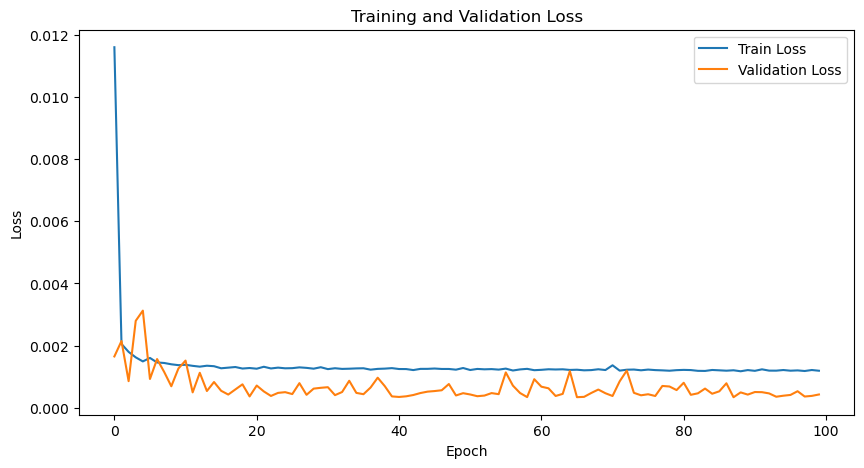

In [3]:
# RNN
# Setting the random seed
torch.manual_seed(42)
np.random.seed(42)

# Detecting whether a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Reading Local Files
train_file = 'Google_Stock_Price_Train.csv'
test_file = 'Google_Stock_Price_Test.csv'

train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

# Select features
features = ['Open', 'High', 'Low', 'Close', 'Volume']
train_data = train_data[features]
test_data = test_data[features]

# Data cleaning: remove commas and convert data to floating point numbers
for feature in features:
    train_data[feature] = train_data[feature].astype(str).str.replace(',', '').astype(float)
    test_data[feature] = test_data[feature].astype(str).str.replace(',', '').astype(float)

# Data preprocessing - combine training and test data and normalize them
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(pd.concat([train_data, test_data]))

# Divide the data into training and testing sets
train_size = len(train_data)
train_scaled = data_scaled[:train_size]
test_scaled = data_scaled[train_size:]

# Creating time series data
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append((seq, label))
    return sequences

SEQ_LENGTH = 10
train_sequences = create_sequences(train_scaled, SEQ_LENGTH)
test_sequences = create_sequences(test_scaled, SEQ_LENGTH)

# Divide the training data into training set and validation set
train_size = int(len(train_sequences) * 0.8)
val_size = len(train_sequences) - train_size
train_sequences, val_sequences = train_sequences[:train_size], train_sequences[train_size:]

# Convert to PyTorch Tensor and create DataLoader
def to_tensor(sequences):
    X = torch.tensor([s[0] for s in sequences], dtype=torch.float32)
    y = torch.tensor([s[1] for s in sequences], dtype=torch.float32)
    return TensorDataset(X, y)

batch_size = 4
train_dataset = to_tensor(train_sequences)
val_dataset = to_tensor(val_sequences)
test_dataset = to_tensor(test_sequences)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Defining the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size=5, hidden_layer_size=50, output_size=5):
        super(RNNModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.rnn = nn.RNN(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        rnn_out, _ = self.rnn(input_seq)
        predictions = self.linear(rnn_out[:, -1, :])  # Only take the output of the last time step
        return predictions

# Model initialization and moving to device
model = RNNModel(input_size=5, hidden_layer_size=50, output_size=5).to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 100
train_losses = []
val_losses = []

for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0
    for seq, labels in train_loader:
        seq, labels = seq.to(device), labels.to(device)
        optimizer.zero_grad()

        y_pred = model(seq)
        loss = loss_function(y_pred, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Verification Phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for seq, labels in val_loader:
            seq, labels = seq.to(device), labels.to(device)
            y_pred = model(seq)
            loss = loss_function(y_pred, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    if epoch % 10 == 0:
        print(f'Epoch {epoch} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}')

# Plotting training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [4]:
# Test set evaluation
model.eval()
test_predictions = []
with torch.no_grad():
    for seq, _ in test_loader:  # Batch testing with test_loader
        seq = seq.to(device)  # Move the input sequence to the device
        y_pred = model(seq)  # Making predictions
        test_predictions.extend(y_pred.cpu().numpy())  # Move predictions to the CPU and convert to NumPy arrays

# Convert y_test to a NumPy array
y_test = np.concatenate([y.numpy() for _, y in test_loader], axis=0)

# Denormalization - Denormalize only the first 5 features
y_test = scaler.inverse_transform(y_test)
test_predictions = np.array(test_predictions)  # Convert to NumPy array
test_predictions = scaler.inverse_transform(test_predictions)
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculates mean absolute percentage error (MAPE)
:param y_true: true value (array or tensor)
:param y_pred: predicted value (array or tensor)
:return: MAPE value
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    epsilon = 1e-10  # Avoid division by 0
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100
# Calculating evaluation metrics
mse = mean_squared_error(y_test, test_predictions)
mae = mean_absolute_error(y_test, test_predictions)
mape = mean_absolute_percentage_error(y_test, test_predictions)  # Adding MAPE


print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'MAPE: {mape:.2f}%')

MSE: 92577849344.0000
MAE: 102283.1484
MAPE: 5.90%


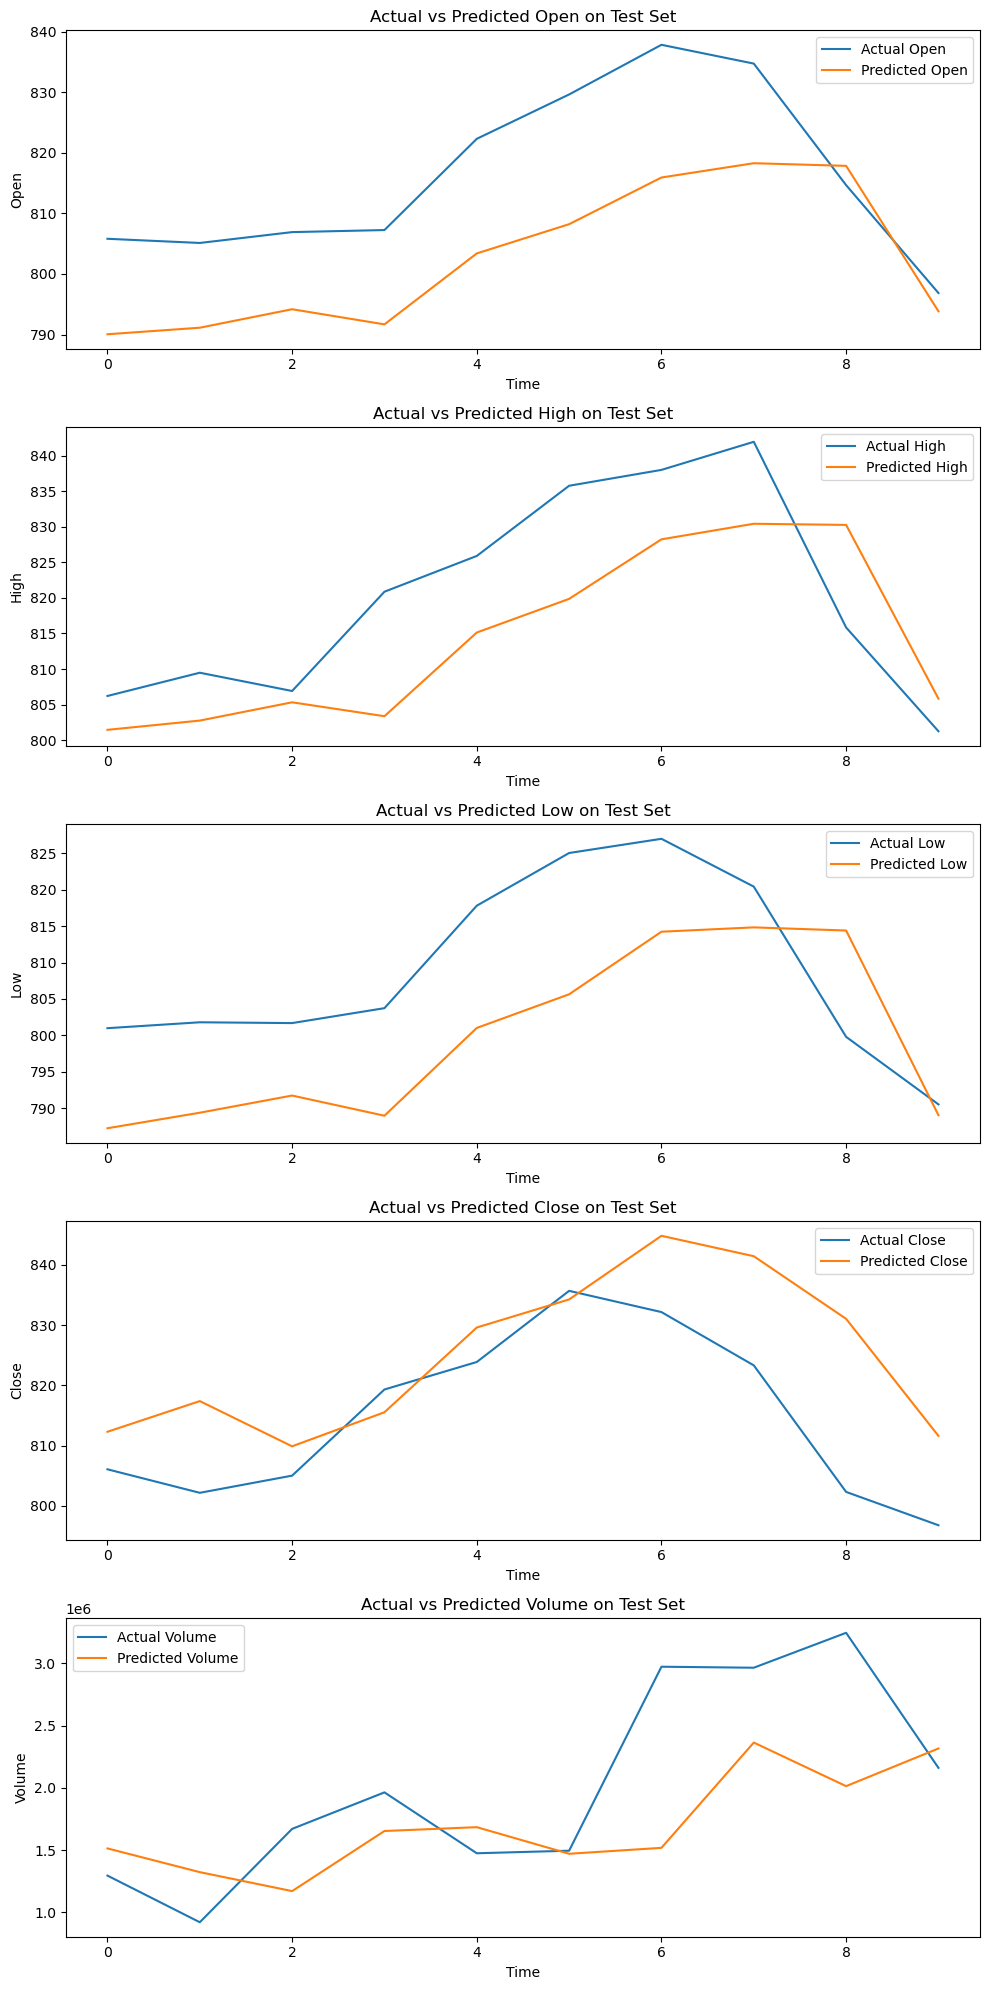

In [5]:
# Plot the actual and predicted values on the test set
plt.figure(figsize=(10, 20))
for i, feature in enumerate(features):
    plt.subplot(5, 1, i + 1)
    plt.plot(y_test[:, i], label=f'Actual {feature}')
    plt.plot(test_predictions[:, i], label=f'Predicted {feature}')
    plt.xlabel('Time')
    plt.ylabel(feature)
    plt.title(f'Actual vs Predicted {feature} on Test Set')
    plt.legend()

plt.tight_layout()
plt.show()

In [5]:
## 2. GRU 

Using device: cpu
3
Epoch 0 - Train Loss: 0.0136 - Val Loss: 0.0011
Epoch 10 - Train Loss: 0.0013 - Val Loss: 0.0010
Epoch 20 - Train Loss: 0.0012 - Val Loss: 0.0006
Epoch 30 - Train Loss: 0.0012 - Val Loss: 0.0004
Epoch 40 - Train Loss: 0.0012 - Val Loss: 0.0003
Epoch 50 - Train Loss: 0.0012 - Val Loss: 0.0016
Epoch 60 - Train Loss: 0.0012 - Val Loss: 0.0004
Epoch 70 - Train Loss: 0.0011 - Val Loss: 0.0004
Epoch 80 - Train Loss: 0.0011 - Val Loss: 0.0004
Epoch 90 - Train Loss: 0.0011 - Val Loss: 0.0004


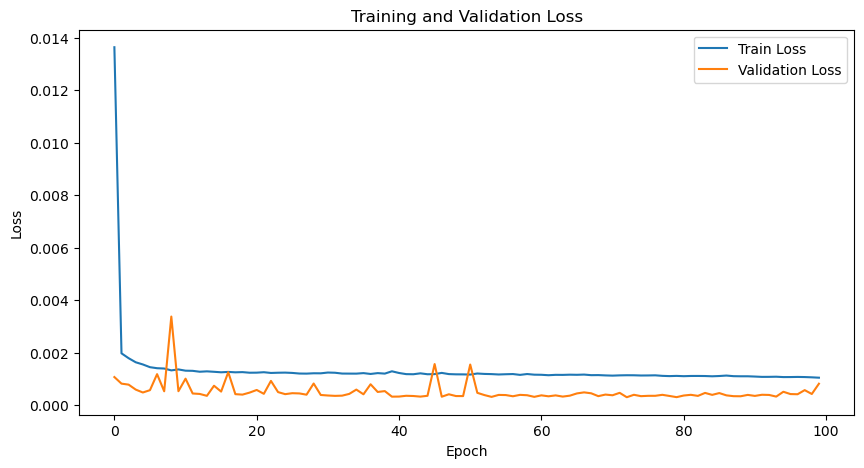

In [6]:
# Setting the random seed
torch.manual_seed(42)
np.random.seed(42)

# Detect if a GPU is available, use the GPU if available, otherwise use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Reading Local Files
train_file = 'Google_Stock_Price_Train.csv'  
test_file = 'Google_Stock_Price_Test.csv'    

train_data = pd.read_csv(train_file)  
test_data = pd.read_csv(test_file)    

# Select features
features = ['Open', 'High', 'Low', 'Close', 'Volume']
train_data = train_data[features]
test_data = test_data[features]

# Data cleaning: remove commas and convert data to floating point numbers
for feature in features:
    train_data[feature] = train_data[feature].astype(str).str.replace(',', '').astype(float)
    test_data[feature] = test_data[feature].astype(str).str.replace(',', '').astype(float)

# Data preprocessing - combine training and test data and normalize them
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(pd.concat([train_data, test_data]))

# Divide the data into training and testing sets
train_size = len(train_data)
train_scaled = data_scaled[:train_size]
test_scaled = data_scaled[train_size:]

# Creating time series data
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append((seq, label))
    return sequences

SEQ_LENGTH = 10
train_sequences = create_sequences(train_scaled, SEQ_LENGTH)
test_sequences = create_sequences(test_scaled, SEQ_LENGTH)

# Divide the training data into training set and validation set
train_size = int(len(train_sequences) * 0.8)
val_size = len(train_sequences) - train_size
train_sequences, val_sequences = train_sequences[:train_size], train_sequences[train_size:]

# Convert to PyTorch Tensor and create DataLoader
def to_tensor(sequences):
    X = torch.tensor([s[0] for s in sequences], dtype=torch.float32)
    y = torch.tensor([s[1] for s in sequences], dtype=torch.float32)
    return TensorDataset(X, y)

batch_size = 4
train_dataset = to_tensor(train_sequences)
val_dataset = to_tensor(val_sequences)
test_dataset = to_tensor(test_sequences)



train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
print(len(test_loader))
# GRU Model definition
class GRUModel(nn.Module):
    def __init__(self, input_size=5, hidden_layer_size=50, output_size=5):
        super(GRUModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.gru = nn.GRU(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        gru_out, _ = self.gru(input_seq)
        predictions = self.linear(gru_out[:, -1, :])  # Only take the output of the last time step
        return predictions

# Model initialization and moving to device
model = GRUModel().to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 100
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for seq, labels in train_loader:
        seq, labels = seq.to(device), labels.to(device)
        optimizer.zero_grad()

        y_pred = model(seq)
        loss = loss_function(y_pred, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Calculate the average training loss
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation set evaluation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for seq, labels in val_loader:
            seq, labels = seq.to(device), labels.to(device)
            y_pred = model(seq)
            loss = loss_function(y_pred, labels)
            val_loss += loss.item()

    # Calculate the average validation loss
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    if epoch % 10 == 0:
        print(f'Epoch {epoch} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}')

# Plotting training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    epsilon = 1e-10  
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

# Test set evaluation
model.eval()
test_predictions = []
with torch.no_grad():
    for seq, _ in test_loader:  # Batch testing with test_loader
        seq = seq.to(device)  # Move the input sequence to the device
        y_pred = model(seq)  # Making predictions
        test_predictions.extend(y_pred.cpu().numpy())  # Move predictions to the CPU and convert to NumPy arrays

# Convert y_test to a NumPy array
y_test = np.concatenate([y.numpy() for _, y in test_loader], axis=0)

# Denormalization - Denormalize only the first 5 features
y_test = scaler.inverse_transform(y_test)
test_predictions = np.array(test_predictions)  # Convert to NumPy array
test_predictions = scaler.inverse_transform(test_predictions)

# Calculation of evaluation indicators
mse = mean_squared_error(y_test, test_predictions)
mae = mean_absolute_error(y_test, test_predictions)
mape = mean_absolute_percentage_error(y_test, test_predictions)  
print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'MAPE: {mape:.2f}%') 

MSE: 75250221056.0000
MAE: 98830.3438
MAPE: 6.78%


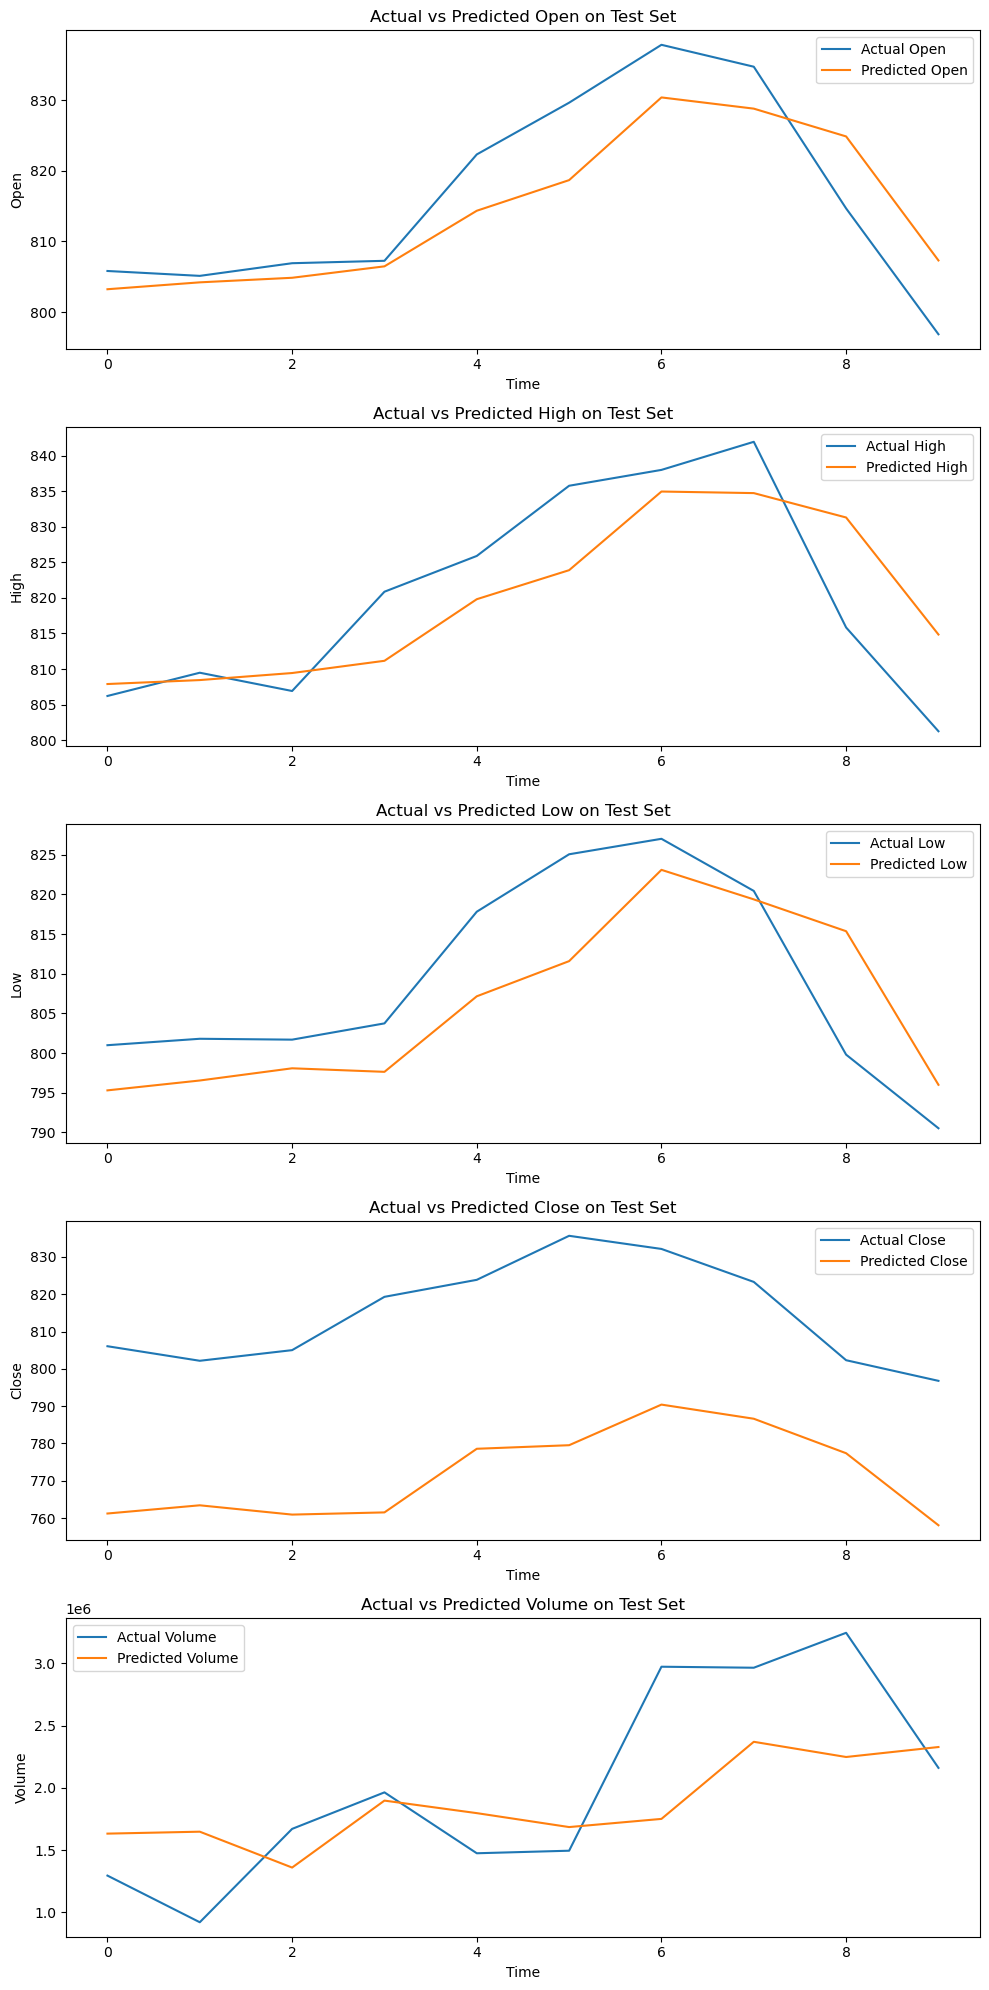

In [8]:
# Plot the actual and predicted values on the test set
features = ['Open', 'High', 'Low', 'Close', 'Volume']
plt.figure(figsize=(10, 20))

for i in range(len(features)):
    plt.subplot(5, 1, i + 1)  
    plt.plot(y_test[:, i], label=f'Actual {features[i]}')
    plt.plot(test_predictions[:, i], label=f'Predicted {features[i]}')
    plt.xlabel('Time')
    plt.ylabel(features[i])
    plt.title(f'Actual vs Predicted {features[i]} on Test Set')
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
## 3. Using the basic LSTM model

Using device: cpu
3
Epoch 0 - Train Loss: 0.0234 - Val Loss: 0.0016
Epoch 10 - Train Loss: 0.0016 - Val Loss: 0.0007
Epoch 20 - Train Loss: 0.0013 - Val Loss: 0.0005
Epoch 30 - Train Loss: 0.0013 - Val Loss: 0.0005
Epoch 40 - Train Loss: 0.0012 - Val Loss: 0.0003
Epoch 50 - Train Loss: 0.0012 - Val Loss: 0.0005
Epoch 60 - Train Loss: 0.0012 - Val Loss: 0.0005
Epoch 70 - Train Loss: 0.0011 - Val Loss: 0.0011
Epoch 80 - Train Loss: 0.0011 - Val Loss: 0.0004
Epoch 90 - Train Loss: 0.0011 - Val Loss: 0.0003


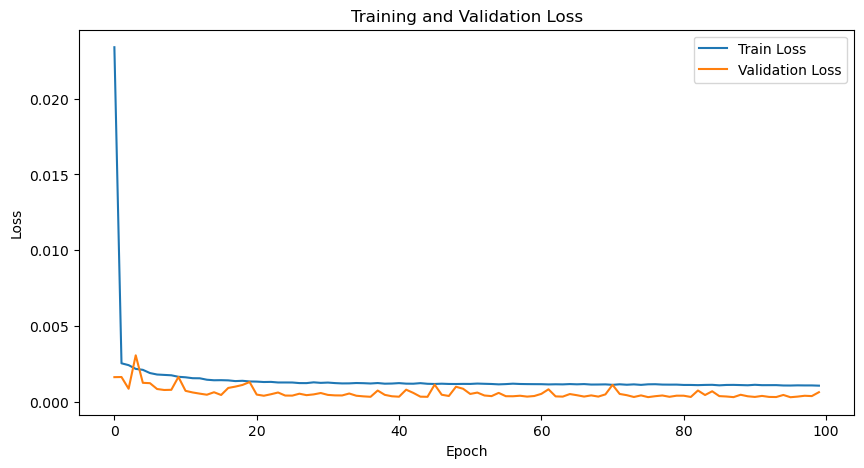

In [9]:
# Setting the random seed
torch.manual_seed(42)
np.random.seed(42)

# Detect if a GPU is available, use the GPU if available, otherwise use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Reading Local Files
train_file = 'Google_Stock_Price_Train.csv'  
test_file = 'Google_Stock_Price_Test.csv'    

train_data = pd.read_csv(train_file)  
test_data = pd.read_csv(test_file)   

# Select features
features = ['Open', 'High', 'Low', 'Close', 'Volume']
train_data = train_data[features]
test_data = test_data[features]

# Data cleaning: remove commas and convert data to floating point numbers
for feature in features:
    train_data[feature] = train_data[feature].astype(str).str.replace(',', '').astype(float)
    test_data[feature] = test_data[feature].astype(str).str.replace(',', '').astype(float)

# Data preprocessing - combine training and test data and normalize them
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(pd.concat([train_data, test_data]))

# Divide the data into training and testing sets
train_size = len(train_data)
train_scaled = data_scaled[:train_size]
test_scaled = data_scaled[train_size:]

# Creating time series data
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append((seq, label))
    return sequences

SEQ_LENGTH = 10
train_sequences = create_sequences(train_scaled, SEQ_LENGTH)
test_sequences = create_sequences(test_scaled, SEQ_LENGTH)

# Divide the training data into training set and validation set
train_size = int(len(train_sequences) * 0.8)
val_size = len(train_sequences) - train_size
train_sequences, val_sequences = train_sequences[:train_size], train_sequences[train_size:]

# Convert to PyTorch Tensor and create DataLoader
def to_tensor(sequences):
    X = torch.tensor([s[0] for s in sequences], dtype=torch.float32)
    y = torch.tensor([s[1] for s in sequences], dtype=torch.float32)
    return TensorDataset(X, y)

batch_size = 4
train_dataset = to_tensor(train_sequences)
val_dataset = to_tensor(val_sequences)
test_dataset = to_tensor(test_sequences)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
print(len(test_loader))

# LSTM model definition
class LSTMModel(nn.Module):
    def __init__(self, input_size=5, hidden_layer_size=50, output_size=5):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :])  
        return predictions

# Model initialization and moving to device
model = LSTMModel().to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 100
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for seq, labels in train_loader:
        seq, labels = seq.to(device), labels.to(device)
        optimizer.zero_grad()

        y_pred = model(seq)
        loss = loss_function(y_pred, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Calculate the average training loss
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation set evaluation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for seq, labels in val_loader:
            seq, labels = seq.to(device), labels.to(device)
            y_pred = model(seq)
            loss = loss_function(y_pred, labels)
            val_loss += loss.item()

    # Calculate the average validation loss
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    if epoch % 10 == 0:
        print(f'Epoch {epoch} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}')

# Plotting training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    epsilon = 1e-10  
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100
# Test set evaluation
model.eval()
test_predictions = []
with torch.no_grad():
    for seq, _ in test_loader:  # Batch testing with test_loader
        seq = seq.to(device)  # Move the input sequence to the device
        y_pred = model(seq)  # Making predictions
        test_predictions.extend(y_pred.cpu().numpy())  # Move predictions to the CPU and convert to NumPy arrays

# Convert y_test to a NumPy array
y_test = np.concatenate([y.numpy() for _, y in test_loader], axis=0)

# Denormalization - Denormalize only the first 5 features
y_test = scaler.inverse_transform(y_test)
test_predictions = np.array(test_predictions)  # Convert to NumPy array
test_predictions = scaler.inverse_transform(test_predictions)

# Calculation of evaluation indicators
mse = mean_squared_error(y_test, test_predictions)
mae = mean_absolute_error(y_test, test_predictions)
mape = mean_absolute_percentage_error(y_test, test_predictions)  
print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'MAPE: {mape:.2f}%')  

MSE: 107696742400.0000
MAE: 128865.3906
MAPE: 9.68%


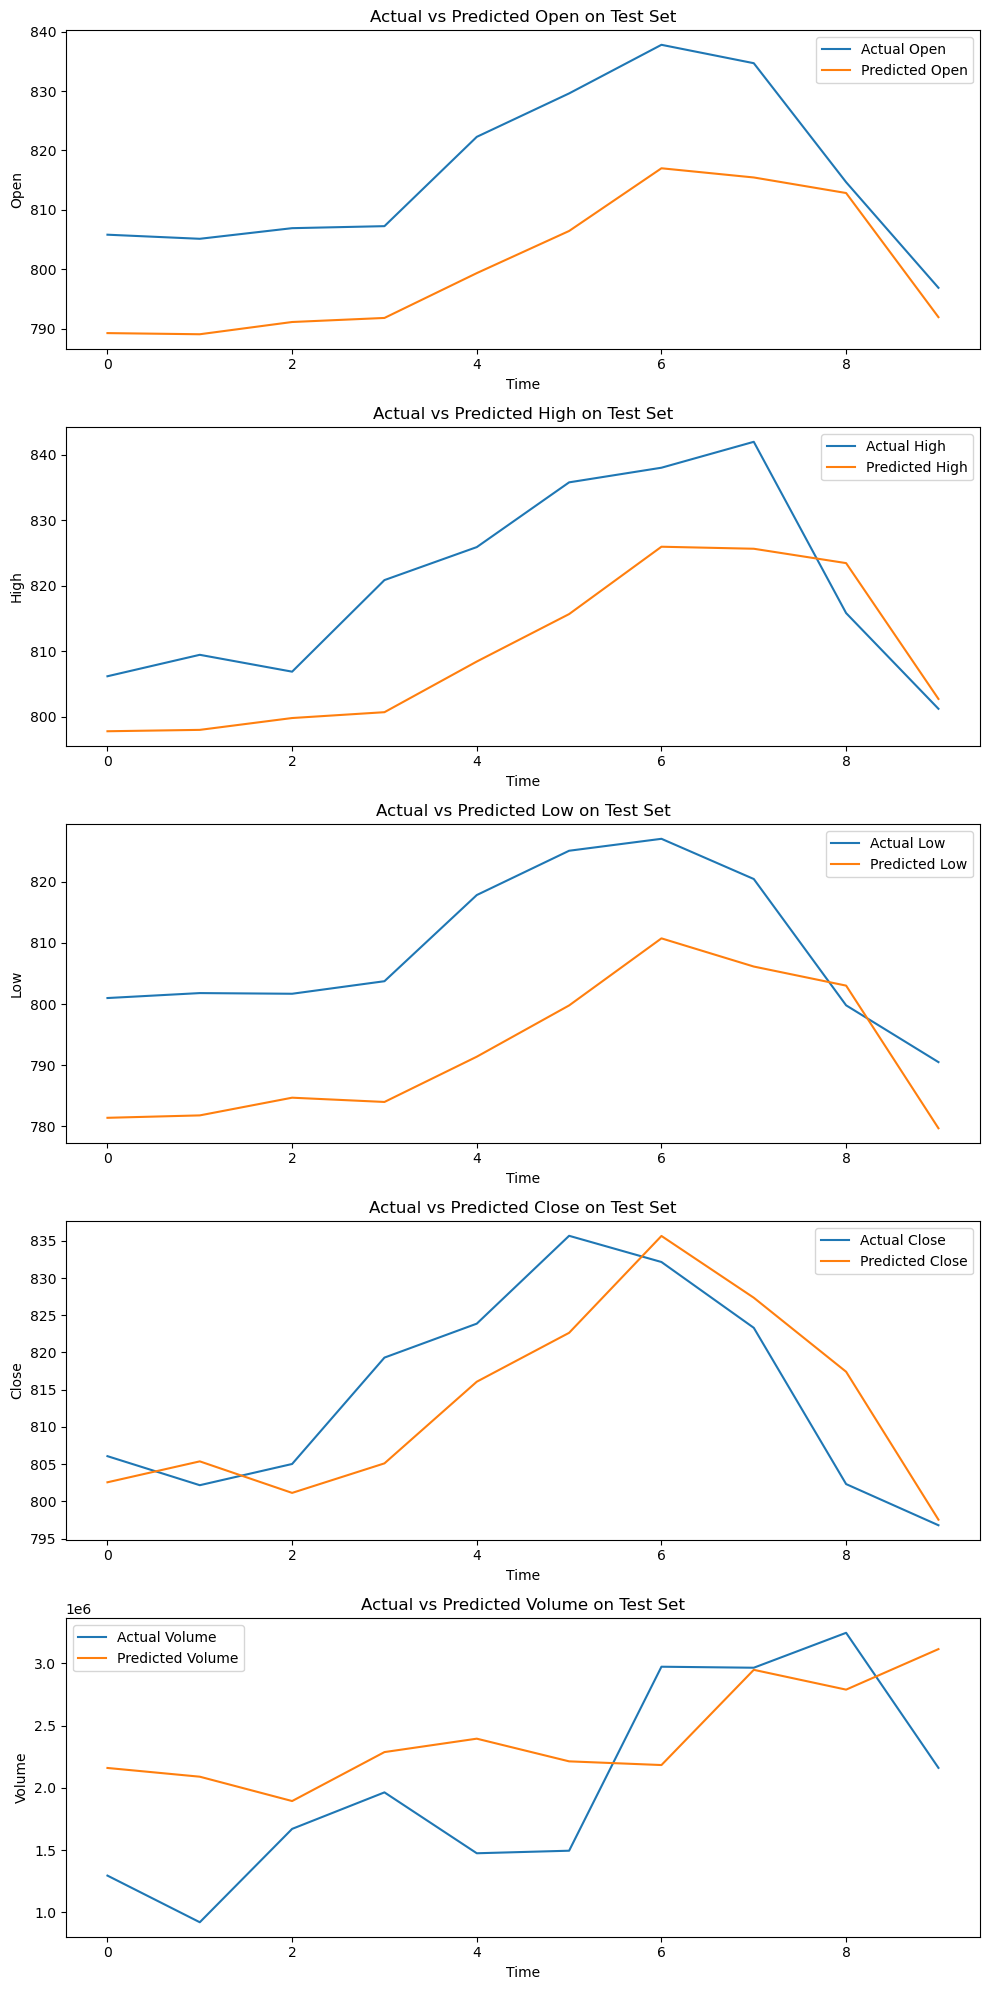

In [11]:
# Plot the actual and predicted values on the test set
features = ['Open', 'High', 'Low', 'Close', 'Volume']
plt.figure(figsize=(10, 20))

for i in range(len(features)):
    plt.subplot(5, 1, i + 1) 
    plt.plot(y_test[:, i], label=f'Actual {features[i]}')
    plt.plot(test_predictions[:, i], label=f'Predicted {features[i]}')
    plt.xlabel('Time')
    plt.ylabel(features[i])
    plt.title(f'Actual vs Predicted {features[i]} on Test Set')
    plt.legend()

plt.tight_layout()
plt.show()

Using device: cpu


C:\Users\pc\AppData\Local\Temp\ipykernel_18088\1502907288.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[feature] = test_data[feature].astype(str).str.replace(',', '').astype(float)


Epoch 0 - Train Loss: 0.0170 - Val Loss: 0.0012
Epoch 10 - Train Loss: 0.0015 - Val Loss: 0.0022
Epoch 20 - Train Loss: 0.0013 - Val Loss: 0.0008
Epoch 30 - Train Loss: 0.0012 - Val Loss: 0.0005
Epoch 40 - Train Loss: 0.0011 - Val Loss: 0.0004
Epoch 50 - Train Loss: 0.0011 - Val Loss: 0.0007
Epoch 60 - Train Loss: 0.0010 - Val Loss: 0.0005
Epoch 70 - Train Loss: 0.0010 - Val Loss: 0.0004
Epoch 80 - Train Loss: 0.0009 - Val Loss: 0.0006
Epoch 90 - Train Loss: 0.0009 - Val Loss: 0.0006


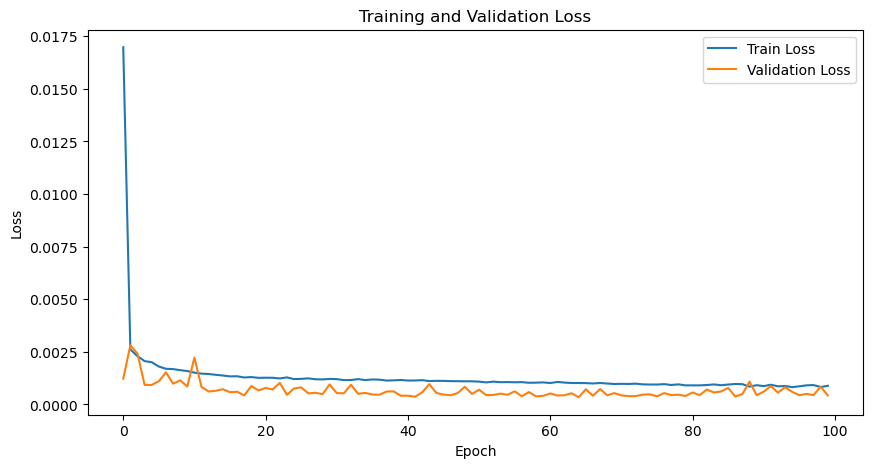

In [12]:
# LSTM with enhanced temporal features
# Setting the random seed
torch.manual_seed(42)
np.random.seed(42)

# Detect if a GPU is available, use the GPU if available, otherwise use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

train_file = 'Google_Stock_Price_Train.csv'  
test_file = 'Google_Stock_Price_Test.csv'   

train_data = pd.read_csv(train_file)  
test_data = pd.read_csv(test_file)    

# Convert the date column to datetime format, if a date column exists
if 'Date' in train_data.columns:
    train_data['Date'] = pd.to_datetime(train_data['Date'])
    test_data['Date'] = pd.to_datetime(test_data['Date'])

    # Extracting time features
    for df in [train_data, test_data]:
        df['Year'] = df['Date'].dt.year
        df['Month'] = df['Date'].dt.month
        df['Day'] = df['Date'].dt.day
        df['DayOfWeek'] = df['Date'].dt.dayofweek  # Day of the week: 0 for Monday, 6 for Sunday

# Select features, including time features
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Year', 'Month', 'Day', 'DayOfWeek']
train_data = train_data[features]
test_data = test_data[features]

#Data cleaning: remove commas and convert data to floating point numbers
for feature in ['Open', 'High', 'Low', 'Close', 'Volume']:
    train_data[feature] = train_data[feature].astype(str).str.replace(',', '').astype(float)
    test_data[feature] = test_data[feature].astype(str).str.replace(',', '').astype(float)

# Data preprocessing - combine training and test data and normalize them
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(pd.concat([train_data, test_data]))

# Divide the data into training and testing sets
train_size = len(train_data)
train_scaled = data_scaled[:train_size]
test_scaled = data_scaled[train_size:]

# Create time series data with only 5 main features
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length][:5]  # Only take the first 5 features as targets
        sequences.append((seq, label))
    return sequences

SEQ_LENGTH = 10
train_sequences = create_sequences(train_scaled, SEQ_LENGTH)
test_sequences = create_sequences(test_scaled, SEQ_LENGTH)

# Divide the training data into training set and validation set
train_size = int(len(train_sequences) * 0.8)
val_size = len(train_sequences) - train_size
train_sequences, val_sequences = train_sequences[:train_size], train_sequences[train_size:]

# Convert to PyTorch Tensor and create DataLoader
def to_tensor(sequences):
    X = torch.tensor([s[0] for s in sequences], dtype=torch.float32)
    y = torch.tensor([s[1] for s in sequences], dtype=torch.float32)
    return TensorDataset(X, y)

batch_size = 4
train_dataset = to_tensor(train_sequences)
val_dataset = to_tensor(val_sequences)
test_dataset = to_tensor(test_sequences)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# LSTM model definition
class LSTMModel(nn.Module):
    def __init__(self, input_size=9, hidden_layer_size=50, output_size=5):  # Predicting 5 key features
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)  # LSTM returns (output, (h_n, c_n))
        predictions = self.linear(lstm_out[:, -1, :])  # Only take the output of the last time step
        return predictions

# Model initialization and moving to device
model = LSTMModel().to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 100
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for seq, labels in train_loader:
        seq, labels = seq.to(device), labels.to(device)
        optimizer.zero_grad()

        y_pred = model(seq)
        loss = loss_function(y_pred, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Calculate the average training loss
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation set evaluation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for seq, labels in val_loader:
            seq, labels = seq.to(device), labels.to(device)
            y_pred = model(seq)
            loss = loss_function(y_pred, labels)
            val_loss += loss.item()

    # Calculate the average validation loss
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    if epoch % 10 == 0:
        print(f'Epoch {epoch} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}')

# Plotting training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [17]:
# Test set evaluation
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    epsilon = 1e-10  
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100
model.eval()
test_predictions = []
with torch.no_grad():
    for seq, _ in test_loader:  # Batch testing with test_loader
        seq = seq.to(device)  # Move the input sequence to the device
        y_pred = model(seq)  # Making predictions
        test_predictions.extend(y_pred.cpu().numpy())  # Move predictions to the CPU and convert to NumPy arrays

# Convert y_test to a NumPy array
y_test = np.concatenate([y.numpy() for _, y in test_loader], axis=0)

# Only the first 5 features are denormalized
# Assuming that the scaler normalizes 9 features, we fill the remaining features with 0
y_test = scaler.inverse_transform(np.hstack([y_test, np.zeros((y_test.shape[0], 4))]))[:, :5]
test_predictions = np.array(test_predictions)
test_predictions = scaler.inverse_transform(np.hstack([test_predictions, np.zeros((test_predictions.shape[0], 4))]))[:, :5]

# Calculation of evaluation indicators
mse = mean_squared_error(y_test, test_predictions)
mae = mean_absolute_error(y_test, test_predictions)
mape = mean_absolute_percentage_error(y_test, test_predictions)
print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'MAPE: {mape:.2f}%') 

MSE: 72843547842.8849
MAE: 103410.9296
MAPE: 7.97%


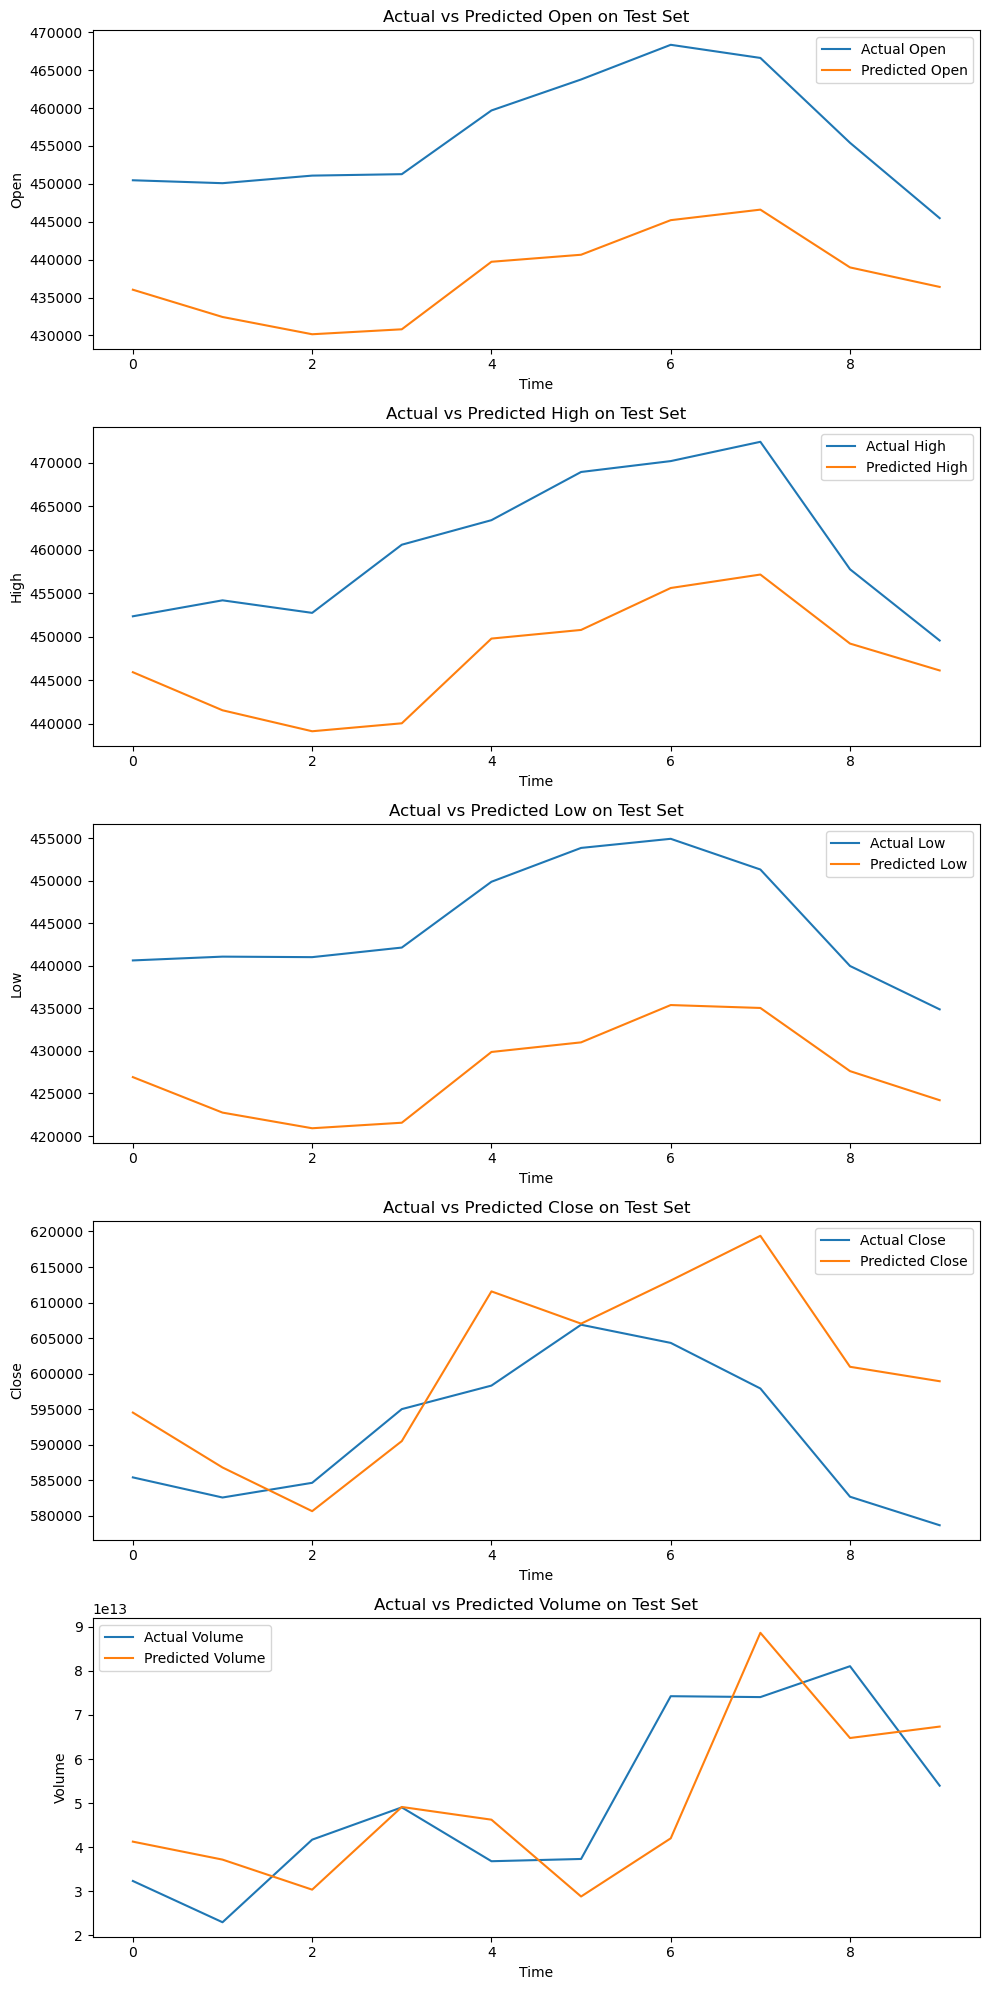

In [19]:
# Plot the actual and predicted values on the test set
features = ['Open', 'High', 'Low', 'Close', 'Volume']
plt.figure(figsize=(10, 20))

for i in range(len(features)):
    plt.subplot(5, 1, i + 1)  # Create 5 subgraphs
    plt.plot(y_test[:, i], label=f'Actual {features[i]}')
    plt.plot(test_predictions[:, i], label=f'Predicted {features[i]}')
    plt.xlabel('Time')
    plt.ylabel(features[i])
    plt.title(f'Actual vs Predicted {features[i]} on Test Set')
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# GRU with enhanced temporal features

Using device: cpu


C:\Users\pc\AppData\Local\Temp\ipykernel_18088\2737216654.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[feature] = test_data[feature].astype(str).str.replace(',', '').astype(float)


Epoch 0 - Train Loss: 0.0066 - Val Loss: 0.0009
Epoch 10 - Train Loss: 0.0014 - Val Loss: 0.0005
Epoch 20 - Train Loss: 0.0013 - Val Loss: 0.0003
Epoch 30 - Train Loss: 0.0012 - Val Loss: 0.0004
Epoch 40 - Train Loss: 0.0011 - Val Loss: 0.0005
Epoch 50 - Train Loss: 0.0010 - Val Loss: 0.0004
Epoch 60 - Train Loss: 0.0008 - Val Loss: 0.0006
Epoch 70 - Train Loss: 0.0008 - Val Loss: 0.0006
Epoch 80 - Train Loss: 0.0007 - Val Loss: 0.0004
Epoch 90 - Train Loss: 0.0006 - Val Loss: 0.0005


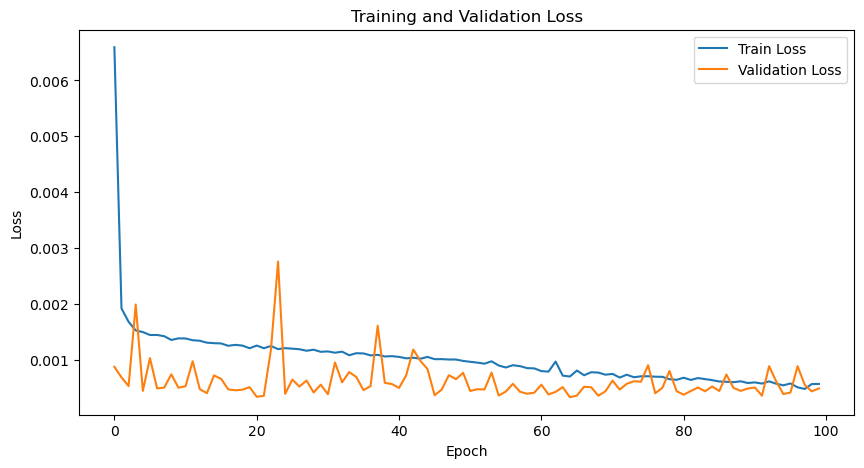

In [20]:
# Setting the random seed
torch.manual_seed(42)
np.random.seed(42)

# Detect if a GPU is available, use the GPU if available, otherwise use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

train_file = 'Google_Stock_Price_Train.csv' 
test_file = 'Google_Stock_Price_Test.csv'    

train_data = pd.read_csv(train_file)  
test_data = pd.read_csv(test_file)    

# Convert the date column to datetime format, if a date column exists
if 'Date' in train_data.columns:
    train_data['Date'] = pd.to_datetime(train_data['Date'])
    test_data['Date'] = pd.to_datetime(test_data['Date'])

    # Extracting time features
    for df in [train_data, test_data]:
        df['Year'] = df['Date'].dt.year
        df['Month'] = df['Date'].dt.month
        df['Day'] = df['Date'].dt.day
        df['DayOfWeek'] = df['Date'].dt.dayofweek  # Day of the week: 0 for Monday, 6 for Sunday

# Select features, including time features
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Year', 'Month', 'Day', 'DayOfWeek']
train_data = train_data[features]
test_data = test_data[features]

# Data cleaning: remove commas and convert data to floating point numbers
for feature in ['Open', 'High', 'Low', 'Close', 'Volume']:
    train_data[feature] = train_data[feature].astype(str).str.replace(',', '').astype(float)
    test_data[feature] = test_data[feature].astype(str).str.replace(',', '').astype(float)

# Data preprocessing - combine training and test data and normalize them
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(pd.concat([train_data, test_data]))

# Divide the data into training and testing sets
train_size = len(train_data)
train_scaled = data_scaled[:train_size]
test_scaled = data_scaled[train_size:]

# Create time series data with only 5 main features
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length][:5]  # Only take the first 5 features as targets
        sequences.append((seq, label))
    return sequences

SEQ_LENGTH = 10
train_sequences = create_sequences(train_scaled, SEQ_LENGTH)
test_sequences = create_sequences(test_scaled, SEQ_LENGTH)

# Divide the training data into training set and validation set
train_size = int(len(train_sequences) * 0.8)
val_size = len(train_sequences) - train_size
train_sequences, val_sequences = train_sequences[:train_size], train_sequences[train_size:]

# 转换为 PyTorch 张量并创建 DataLoader
def to_tensor(sequences):
    X = torch.tensor([s[0] for s in sequences], dtype=torch.float32)
    y = torch.tensor([s[1] for s in sequences], dtype=torch.float32)
    return TensorDataset(X, y)

batch_size = 1
train_dataset = to_tensor(train_sequences)
val_dataset = to_tensor(val_sequences)
test_dataset = to_tensor(test_sequences)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# GRU Model definition
class GRUModel(nn.Module):
    def __init__(self, input_size=9, hidden_layer_size=50, output_size=5):
        super(GRUModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.gru = nn.GRU(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        gru_out, _ = self.gru(input_seq)
        predictions = self.linear(gru_out[:, -1, :])  # Only take the output of the last time step
        return predictions

# Model initialization and moving to device
model = GRUModel().to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 100
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for seq, labels in train_loader:
        seq, labels = seq.to(device), labels.to(device)
        optimizer.zero_grad()

        y_pred = model(seq)
        loss = loss_function(y_pred, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Calculate the average training loss
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation set evaluation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for seq, labels in val_loader:
            seq, labels = seq.to(device), labels.to(device)
            y_pred = model(seq)
            loss = loss_function(y_pred, labels)
            val_loss += loss.item()

    # Calculate the average validation loss
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    if epoch % 10 == 0:
        print(f'Epoch {epoch} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}')

# Plotting training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [21]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    epsilon = 1e-10  # Avoid division by 0
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100
# Test set evaluation
model.eval()
test_predictions = []
with torch.no_grad():
    for seq, _ in test_loader:  # Batch testing with test_loader
        seq = seq.to(device)  # Move the input sequence to the device
        y_pred = model(seq)  # Making predictions
        test_predictions.extend(y_pred.cpu().numpy())  # Move predictions to the CPU and convert to NumPy arrays

# Convert y_test to a NumPy array
y_test = np.concatenate([y.numpy() for _, y in test_loader], axis=0)

# Only the first 5 features are denormalized
# Assuming that the scaler normalizes 9 features, we fill the remaining features with 0
y_test = scaler.inverse_transform(np.hstack([y_test, np.zeros((y_test.shape[0], 4))]))[:, :5]
test_predictions = np.array(test_predictions)
test_predictions = scaler.inverse_transform(np.hstack([test_predictions, np.zeros((test_predictions.shape[0], 4))]))[:, :5]

# Calculation of evaluation indicators
mse = mean_squared_error(y_test, test_predictions)
mae = mean_absolute_error(y_test, test_predictions)
mape = mean_absolute_percentage_error(y_test, test_predictions)
print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'MAPE: {mape:.2f}%')

MSE: 139419458554.7722
MAE: 111903.9859
MAPE: 7.09%


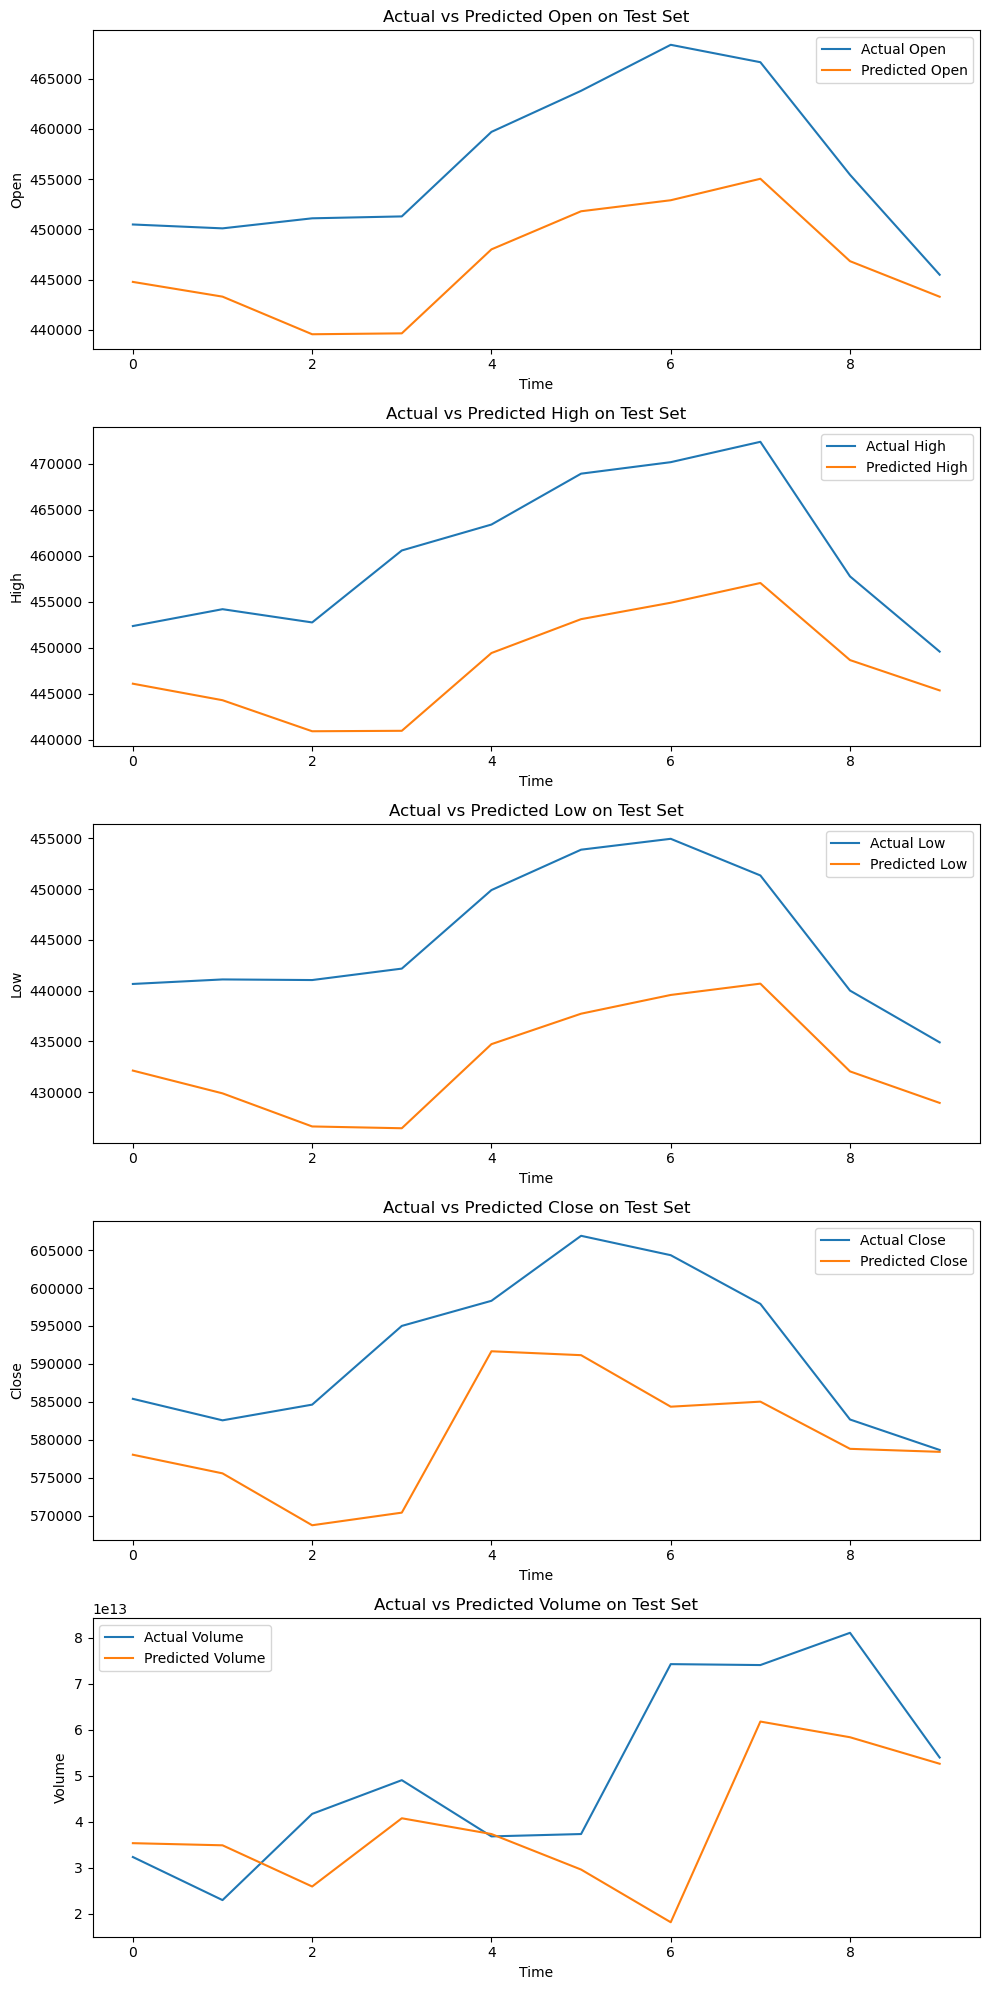

In [23]:
# Plot the actual and predicted values on the test set
features = ['Open', 'High', 'Low', 'Close', 'Volume']
plt.figure(figsize=(10, 20))

for i in range(len(features)):
    plt.subplot(5, 1, i + 1)  # Create 5 subgraphs
    plt.plot(y_test[:, i], label=f'Actual {features[i]}')
    plt.plot(test_predictions[:, i], label=f'Predicted {features[i]}')
    plt.xlabel('Time')
    plt.ylabel(features[i])
    plt.title(f'Actual vs Predicted {features[i]} on Test Set')
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Building a CNN-GRU hybrid model

Using device: cpu


C:\Users\pc\AppData\Local\Temp\ipykernel_18088\4095755760.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[feature] = test_data[feature].astype(str).str.replace(',', '').astype(float)


Epoch 0 - Train Loss: 0.0333 - Val Loss: 0.0036
Epoch 10 - Train Loss: 0.0016 - Val Loss: 0.0007
Epoch 20 - Train Loss: 0.0014 - Val Loss: 0.0007
Epoch 30 - Train Loss: 0.0013 - Val Loss: 0.0006
Epoch 40 - Train Loss: 0.0012 - Val Loss: 0.0005
Epoch 50 - Train Loss: 0.0012 - Val Loss: 0.0007
Epoch 60 - Train Loss: 0.0012 - Val Loss: 0.0005
Epoch 70 - Train Loss: 0.0012 - Val Loss: 0.0004
Epoch 80 - Train Loss: 0.0011 - Val Loss: 0.0006
Epoch 90 - Train Loss: 0.0011 - Val Loss: 0.0004


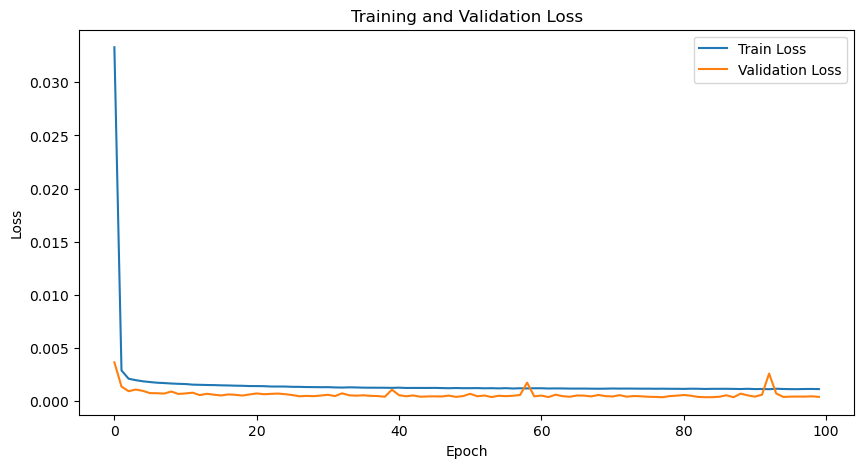

In [28]:
# Setting the random seed
torch.manual_seed(42)
np.random.seed(42)

# Detect if a GPU is available, use the GPU if available, otherwise use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

train_file = 'Google_Stock_Price_Train.csv'  
test_file = 'Google_Stock_Price_Test.csv'    

train_data = pd.read_csv(train_file) 
test_data = pd.read_csv(test_file)    

# Convert the date column to datetime format, if a date column exists
if 'Date' in train_data.columns:
    train_data['Date'] = pd.to_datetime(train_data['Date'])
    test_data['Date'] = pd.to_datetime(test_data['Date'])

    # Extracting time features
    for df in [train_data, test_data]:
        df['Year'] = df['Date'].dt.year
        df['Month'] = df['Date'].dt.month
        df['Day'] = df['Date'].dt.day
        df['DayOfWeek'] = df['Date'].dt.dayofweek  # Day of the week: 0 for Monday, 6 for Sunday

# Select features, including time features
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Year', 'Month', 'Day', 'DayOfWeek']
train_data = train_data[features]
test_data = test_data[features]

for feature in ['Open', 'High', 'Low', 'Close', 'Volume']:
    train_data[feature] = train_data[feature].astype(str).str.replace(',', '').astype(float)
    test_data[feature] = test_data[feature].astype(str).str.replace(',', '').astype(float)

# Data preprocessing - combine training and test data and normalize them
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(pd.concat([train_data, test_data]))

# Divide the data into training and testing sets
train_size = len(train_data)
train_scaled = data_scaled[:train_size]
test_scaled = data_scaled[train_size:]

# Create time series data with only 5 main features
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length][:5]  # Only take the first 5 features as targets
        sequences.append((seq, label))
    return sequences

SEQ_LENGTH = 10
train_sequences = create_sequences(train_scaled, SEQ_LENGTH)
test_sequences = create_sequences(test_scaled, SEQ_LENGTH)

# Divide the training data into training set and validation set
train_size = int(len(train_sequences) * 0.8)
val_size = len(train_sequences) - train_size
train_sequences, val_sequences = train_sequences[:train_size], train_sequences[train_size:]

# Convert to PyTorch Tensor and create DataLoader
def to_tensor(sequences):
    X = torch.tensor([s[0] for s in sequences], dtype=torch.float32)
    y = torch.tensor([s[1] for s in sequences], dtype=torch.float32)
    return TensorDataset(X, y)

batch_size = 1
train_dataset = to_tensor(train_sequences)
val_dataset = to_tensor(val_sequences)
test_dataset = to_tensor(test_sequences)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

class CNNGRUModel(nn.Module):
    def __init__(self, input_size=9, hidden_layer_size=50, output_size=5, cnn_out_channels=32, kernel_size=3):
        super(CNNGRUModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        
        # CNN Layers
        self.cnn = nn.Conv1d(in_channels=input_size, 
                             out_channels=cnn_out_channels, 
                             kernel_size=kernel_size, 
                             padding=kernel_size // 2)  # Use padding to keep input and output the same length
        
        # GRU Layer
        self.gru = nn.GRU(cnn_out_channels, hidden_layer_size, batch_first=True)
        
        # Fully connected layer
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        # input_seq: (batch_size, seq_length, input_size)
        
        # Reshape input_seq to fit CNN layer
        input_seq = input_seq.permute(0, 2, 1)  # becomes (batch_size, input_size, seq_length)
        cnn_out = self.cnn(input_seq)          # Through CNN layers (batch_size, cnn_out_channels, seq_length)
        cnn_out = cnn_out.permute(0, 2, 1)     # Change back to (batch_size, seq_length, cnn_out_channels)
        
        # Through the GRU layer
        gru_out, _ = self.gru(cnn_out)         # (batch_size, seq_length, hidden_layer_size)
        
        # Take the output of the last time step
        predictions = self.linear(gru_out[:, -1, :])  # Only take the output of the last time step (batch_size, output_size)
        return predictions

# Model initialization and moving to device
model = CNNGRUModel().to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training the model
epochs = 100
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for seq, labels in train_loader:
        seq, labels = seq.to(device), labels.to(device)
        optimizer.zero_grad()

        y_pred = model(seq)
        loss = loss_function(y_pred, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Calculate the average training loss
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation set evaluation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for seq, labels in val_loader:
            seq, labels = seq.to(device), labels.to(device)
            y_pred = model(seq)
            loss = loss_function(y_pred, labels)
            val_loss += loss.item()

    # Calculate the average validation loss
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    if epoch % 10 == 0:
        print(f'Epoch {epoch} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}')

# Plotting training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [29]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    epsilon = 1e-10  # Avoid division by 0
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100
# Test set evaluation
model.eval()
test_predictions = []
with torch.no_grad():
    for seq, _ in test_loader:  # Batch testing with test_loader
        seq = seq.to(device)  # Move the input sequence to the device
        y_pred = model(seq)  # Making predictions
        test_predictions.extend(y_pred.cpu().numpy())  # Move predictions to the CPU and convert to NumPy arrays

# Convert y_test to a NumPy array
y_test = np.concatenate([y.numpy() for _, y in test_loader], axis=0)

# Only the first 5 features are denormalized
# Assuming that the scaler normalizes 9 features, we fill the remaining features with 0
y_test = scaler.inverse_transform(np.hstack([y_test, np.zeros((y_test.shape[0], 4))]))[:, :5]
test_predictions = np.array(test_predictions)
test_predictions = scaler.inverse_transform(np.hstack([test_predictions, np.zeros((test_predictions.shape[0], 4))]))[:, :5]

# Calculation of evaluation indicators
mse = mean_squared_error(y_test, test_predictions)
mae = mean_absolute_error(y_test, test_predictions)
mape = mean_absolute_percentage_error(y_test, test_predictions)
print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'MAPE: {mape:.2f}%')

MSE: 94153011696.9408
MAE: 114753.9773
MAPE: 6.72%


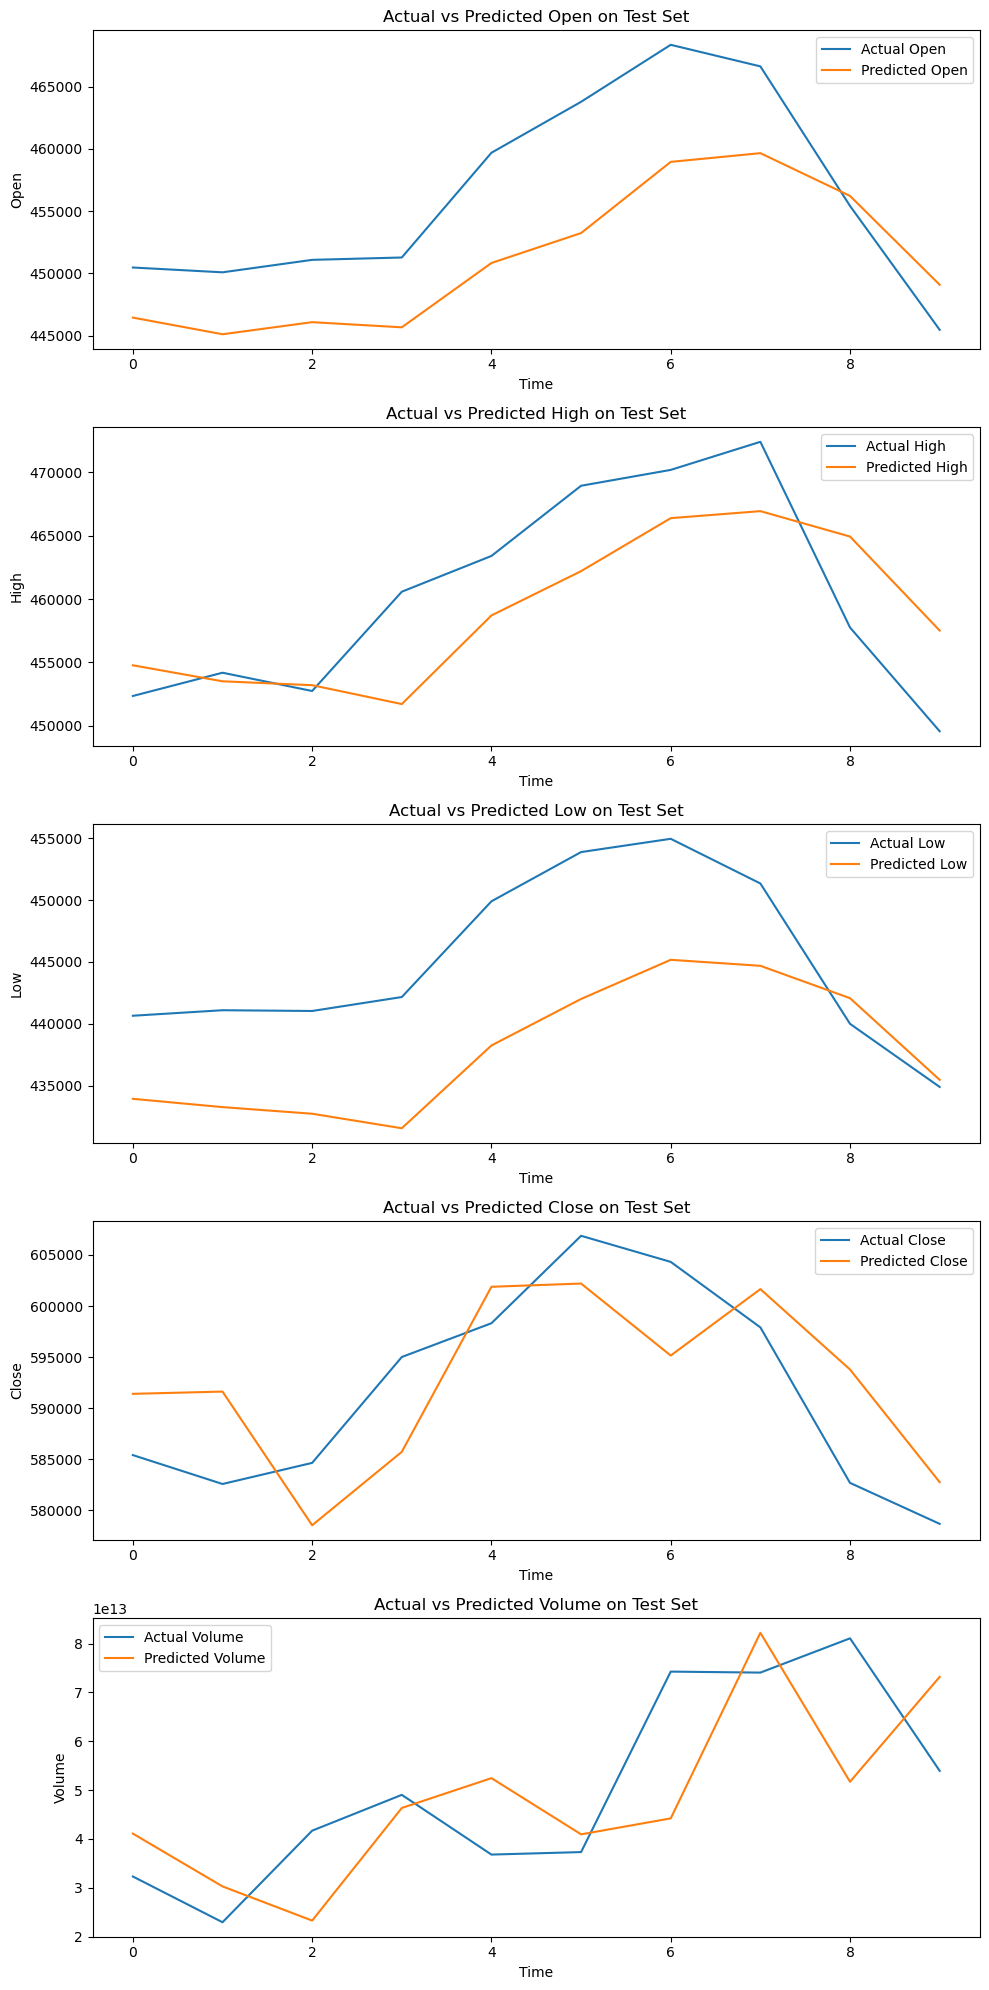

In [31]:
# Plot the actual and predicted values on the test set
features = ['Open', 'High', 'Low', 'Close', 'Volume']
plt.figure(figsize=(10, 20))

for i in range(len(features)):
    plt.subplot(5, 1, i + 1)  # Create 5 subgraphs
    plt.plot(y_test[:, i], label=f'Actual {features[i]}')
    plt.plot(test_predictions[:, i], label=f'Predicted {features[i]}')
    plt.xlabel('Time')
    plt.ylabel(features[i])
    plt.title(f'Actual vs Predicted {features[i]} on Test Set')
    plt.legend()

plt.tight_layout()
plt.show()